<a href="https://colab.research.google.com/github/nabinyd/60-Days-of-learning/blob/main/DLPT_06_PyTorch__Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 33

## Transfer Learning OverView

**Transfer Learning** is a machine learning technique where a model developed for a particular task is reused as the starting point for a model on a second task. This approach leverages pre-trained models on large datasets, typically for task like image classification or natural language processing (NLP) , and fine-tunes then for specific, often smaller related tasks. This method is highly efficient, both in terms of computational resources and time, compared to training a model from scratch.

Imagine you're learning a new sport. if you already know how to play a similar sport, you'll likely pick up the new one faster. Transfer learning works in a similar way for machines.


**Key Concepts**:

1. **Pre-trained models**: Models that have been previously trained on a large dataset and are used as the foundation for a new, related task.

2. **Fine-tuning**: Adjusting the pre-trained model's parameter's for the specific target task.

3. **Feature extraction**: Using the pre-trained model's layers to extract features from new data without modifying the weights of these layers.

4. **Base Model**: The original pre-trained model before any fine-tuning or modification for a new task








### **Why use Transfer learning?**

1. **Efficiency**: Reduces training time significantly as the model has already learned useful features from the large dataset.

2. **Performance**: Often yields better performance, especially when the target dataset is small or similar to the dataset the model was originally trained on.

3. **Resource Utilization**: Makes effective use of computational resources, as training a  model from scratch can be highly resource-intensive.

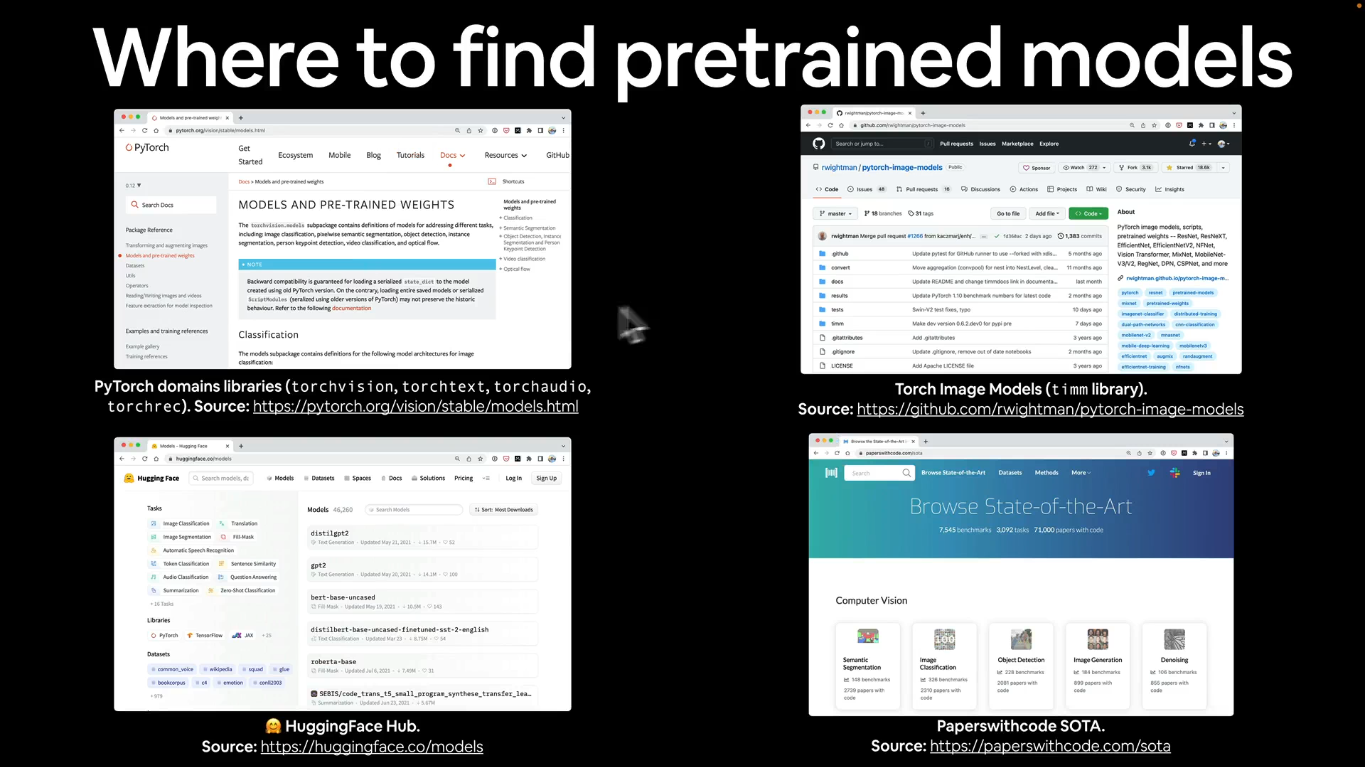

## **What we are going to cover?**

  * Getting setup (importing previously written code)
  * Introduce transfer learning with PyTorch
  * Customise a pretrained model for our own use case (FoodVision mini)
  * Evaluating a transfer learning model
  * Making a transfer learning model
  * Making predictions on our own custom data

In [1]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.3.0+cu121
0.18.0+cu121


In [2]:
from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if doesn't work
try:
  from torchinfo import summary
except:
  print("[INFO] Coudn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

# Try to import the going _modular directory, download it from github if it doesn't work
try:
  from going_modular.going_modular import data_setup, engine
except:
  # Get the going_modular scripts
  print("[INFO] Coudn't find going_modular scripts... downloading them from github." )
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  # !rm -rf pytorch-deep-learning
  # from going_modular.going_modular import data_setup, engine

[INFO] Coudn't find torchinfo... installing it.
[INFO] Coudn't find going_modular scripts... downloading them from github.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 26.11 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [3]:
!rm -rf pytorch-deep-learning

In [4]:
from going_modular.going_modular import data_setup, engine

In [5]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data
We need our pizaa, steak, sushi data to build a transfer learning model on.


In [6]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [7]:
# setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# Day 34

## 2. Create Datrasets and DataLoaders

Now we've got some data, want to turn it into PyTorch DataLoaders.
To do so, we can use `data_setup.py` and `create_dataloaders()` function we made in 05.PyTorch_ going _modular


There's one thing we have to think about when loading: how to **transform** it?

1. Manually created transforms - you define what transforms you want your data to go through.
2. Automatically created transforms - the transforms for your data are defined by the model you'd like to use.


**Important point:** When using a pretrained model, it's important that the data (including your custom data) that you pass through it is transformed in the same way that the data the model was trained on.

In [8]:
from going_modular.going_modular import data_setup


### 2.1  Creating a transform for `torchvision.models` (manaul creation)

`torchvision.models` contains pretrained models (models ready for transfer learning) right wihtin `torchvision`.

In [9]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224,224)),   # resize image to 224, 224 (height * width)
    transforms.ToTensor(),   # get images into range [0, 1]
    normalize  # make sure images have the same distribution as ImageNet (where our pretrained models have been trained)
])

In [10]:
from going_modular.going_modular import data_setup
train_dataloader, test_datalaoder, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)

train_dataloader, test_datalaoder, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d1ecbb04610>,
 ['pizza', 'steak', 'sushi'])

 ### 2.2 Creating a transform for `torchvision.models` (auto creation)



In [11]:
import torchvision


In [12]:
# Get a set of pretraine d model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT   #  "DEFAULT" = best available
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [13]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [14]:
# Create dataloader using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)

train_dataloader

# Day 35

## 3. Getting a pretrained model

There are various places to get a pretrained model, such as:

    1. PyTorch domain ibraries
    2. Librearies like `timm` (torch image models)
    3. HuggingFace Hub (for plenty of different models)
    4. Paperswithcode (for models across different problem spaces/domains)

### 3.1 Which pretrained  model should you use?

*Experiment, experiment, experiment!*

The whole idea of transfer learning: take an already well- performing model from a problem space similar to your own and then customize to your own problem.


Three things to consider:
1. Speed - how fast does it run?
2. Size - how big is the model?
3. Performance - how well does it go on your chosen problem (e.g how well does it classify food images? for foodvision mini)

Where does the model live?

Is it on device? (like a self-driving car)

or it live on a server?

### 3.2 Setting up pretrained model




In [15]:
# OLD method of creatung a pretrained model (prior to torchvision)
# model = torchvision.models.efficientnet_b0(pretrained=True )

# New mrthod of creating pretrained model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 82.4MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [16]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

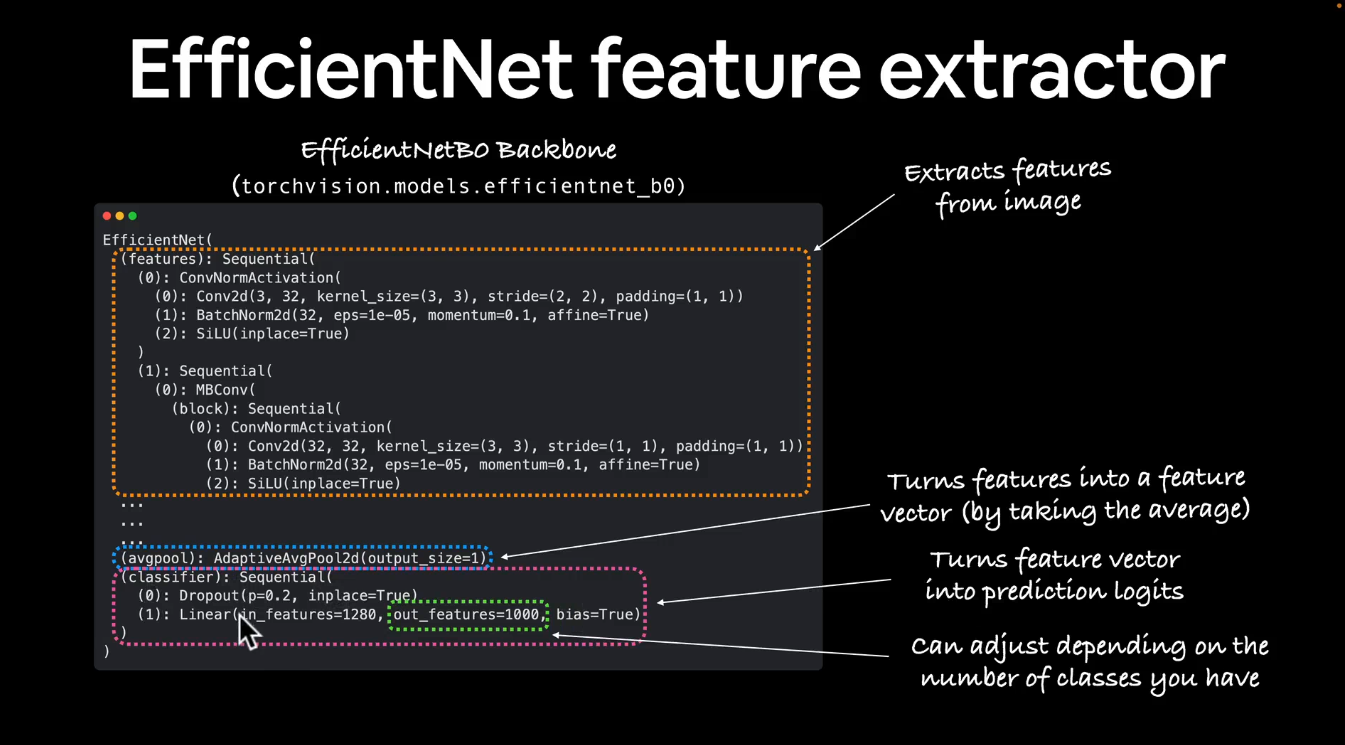

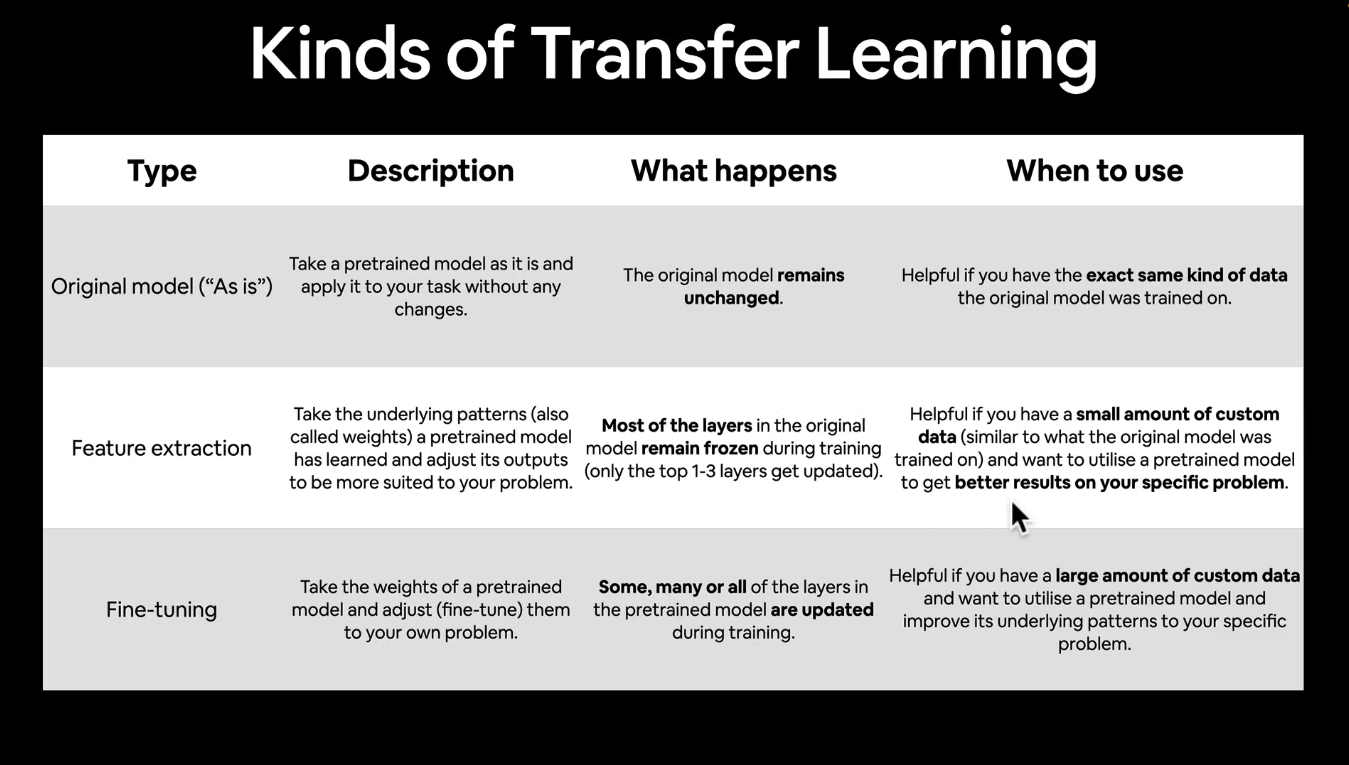

### 3.3 Getting a summary  of our model with `torchinfo.summary()`

In [17]:
# Print with torchinfo
from torchinfo import summary
summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [18]:
summary(model=model)

Layer (type:depth-idx)                                  Param #
EfficientNet                                            --
├─Sequential: 1-1                                       --
│    └─Conv2dNormActivation: 2-1                        --
│    │    └─Conv2d: 3-1                                 864
│    │    └─BatchNorm2d: 3-2                            64
│    │    └─SiLU: 3-3                                   --
│    └─Sequential: 2-2                                  --
│    │    └─MBConv: 3-4                                 1,448
│    └─Sequential: 2-3                                  --
│    │    └─MBConv: 3-5                                 6,004
│    │    └─MBConv: 3-6                                 10,710
│    └─Sequential: 2-4                                  --
│    │    └─MBConv: 3-7                                 15,350
│    │    └─MBConv: 3-8                                 31,290
│    └─Sequential: 2-5                                  --
│    │    └─MBConv: 3-9         

### 3.4 Freezing the base model and changing the output layer to suit our needs

with a feature extractor model, typically you will "freeze" the base layers of a pretrained/ foundation model and update the output layers to suit your own problem.

In [19]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
  # print(param)
  param.requires_grad = False

In [20]:
## Update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
model.classifier  = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,   # feature vector coming in
              out_features=len(class_names))
)

In [21]:
summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [22]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## 4. Train model

In [23]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
# Import train function
from going_modular.going_modular import engine


# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)


# Start the timer
from timeit import default_timer as timer
start_time = timer()


# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
[INFO] Total training time: 20.375 seconds


## 5. Evaluate model by plotting curves

In [25]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f"[INFO] Couldn't find helper_functions.py, downloading...")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves


[INFO] Couldn't find helper_functions.py, downloading...


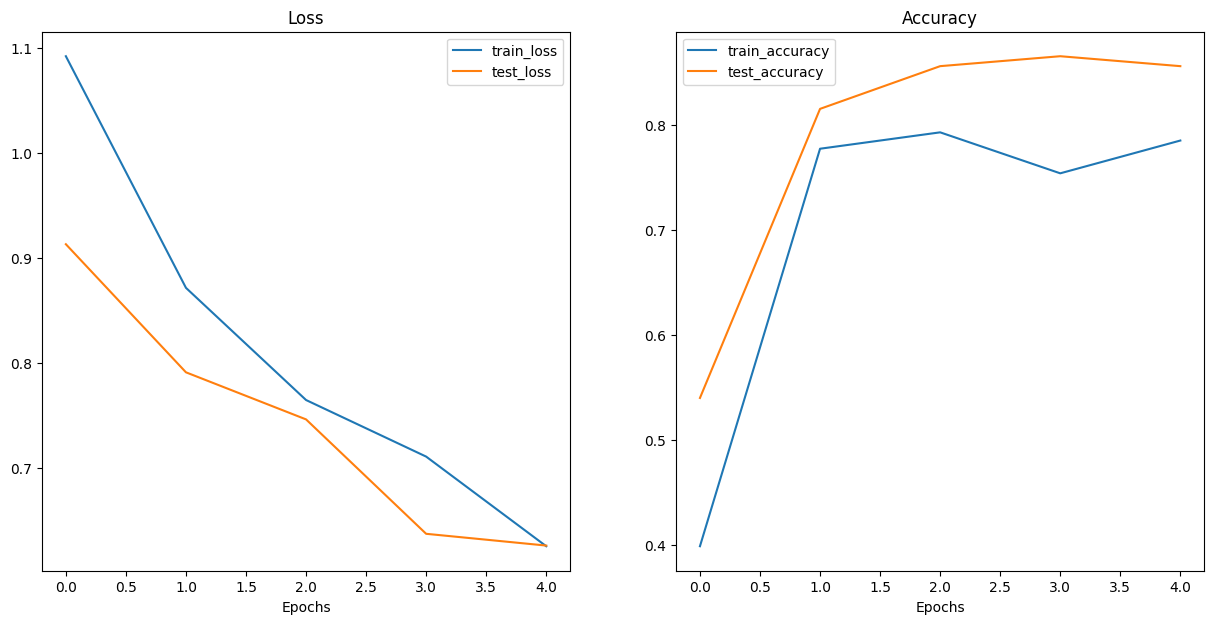

In [26]:
plot_loss_curves(results)

### 5.1 Detailed analysis of Model Performance Curves

**1. Loss vs. Epochs**

`Y-axis`: Loss (typically, this is a measure of error such as MEAn Squared Error (MSE) for regrssion or Cross-Entropy Loss for classfication).

`X-axis`: Epochs (each epoch represents one complete pass through the entire training dataset).

`Blue Line (train loss)`: This line represent the loss on the training data over epochs. A decresing trend indicates that the model is learning and fitting the training data better as training progresses.

`Orange Line (test_loss)`: This line represents the loss on the testing (or validation) data over epochs. A decresing trend here suggests that the model is also improving its performance  on unseen data, which is a good sign of generalization.

**Key observations**:
   
   * **Epoch 0 to 1:**
     * **Train loss**: Starts relatively high and drops significantly. This is comman as the model begins to learn the patterns in the training data.

     * **Test Loss**: Also starts high but decreases, suggesting th emodel is begining to generalize from the start.
   
   * **Epoch 1 to 2**:
     * **Train Loss**: Continues to decrease, but at a slower rate. The initial rapid drop is often followed by more gradual decrease as the model fine-tunes its weights.
     * **Test Loss**: Continues to decrease and stays loweer than the training loss, which is an indication of good generalization.

   * **Epoch 2 to 4**:
     * **Train Loss**: Keeps decreasing. The model continues to learn and reduce the error on the training data.

     * **Test Loss**: Also decreases, but with some fluctuations. These fluctuations are normal and can indicaate the variance in the testing data or the model's adjustments.

**Summary**: The decreasing trend in both training and testing loss is a positive sign. The fact that the test loss is lower than the train loss suggests that the model is not overfitting and is generalizing well to unseen data.


**Accuracy vs. Epochs**

`Y-axis`: Accuracy(the fraction of correctr predictions can be overall accuracy for classification tasks).

`X-asis`: Epochs (similar to the loss plot).

`Blue line (train_accuracy)`: This line represents the accuracy on the training data over epochs. An increasing trend indicates model's improved ability to make correct predictions on the training data.


`Orange line (test_accuracy)`: This line represents the accuracy on the testing data over epochs. An increasing trend suggests that the model is also making correct predictions on unseen data.

**Key Observations**:

*  **Epoch 0 to 2:**
     * **Train accuracy**: Starts low but increases significantly. The model is beginning to correctly classify or predict the training data.

     * **Test accuracy**: Also starts low but increases, indicating good initial generalization.

*  **Epoch 1 to 2**:
    * **Train Accuracy**: Continues to increase steadily. The model is learning and becoming more accurate on the training data.
    
    * **Test Accuracy**:   Increases and surpasses the train accuracy. This could indicate that the model's learning rate and capacity are well-suited to the data.


*  **Epoch 2 to 4**:
    * **Train Accuracy**: Keeps increasing, although there is a drop around epoch 3, possibly due to an adjustment or re-learning phase in the model.

    * **Test Accuracy**:   Increases initially but then shows slight fluctuations. Despite these, it remains higher than the train accuracy.



**Summary**: The increasing trend in both training and testing accuracy indicates that the model is improving in performance. The higher test accuracy suggests that the model is not overfitting and is generalizing well to unseen data, despite the fluctuations.

# Day 36

## 6. Make predictions on images from the test set

Let's adhere to the data explorer's motto of *visualize, visualizze, visualize*!

And make some qualitative predictions on our test set.

Some things to keep in mind when making predictions/inference on test data/custom data.


We have to make sure that our test/custom data is:
* Same shape - images need to be same shape as model was trained on
* Same datatype - custom data should be in the same data type
* Same device - custom data/set data should be on the same device as the model

* Same transform - if you've transformed your custom data, ideally you will transform the test data and custom data the same

To do all this automatically, let's create a function called `pred_and_plot_image()`:

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device

2. Open the image with `PIL.Image.Open()`
3. Create a transform if one doesn't exist
4. Make sure the model is on the target device
5. Turn the model to `model.eval()` mode to make sure it's ready for inference (this will turn off things like `nn.Dropout()`)
6. Transform the target image and make sure its dimesionality is suited for yhe model (this mainly relates to batch size)
7. Make a prediction on the image by passing to the model
8. Convert the model's output logits to prediction probabilities using `torch.softmax()`
9. Convert model's prediction probabilities to predictionj labels using `torch.argmax()`
10. Plot th eimage with `matplotlib` and set the title to the prediction label from step 9 and prediction probabiliity  from step 8

In [33]:
from typing import List, Tuple

from PIL import Image

from torchvision import transforms
import matplotlib.pyplot as plt

# 1. Take in a trained model...


def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device = device):
  # 2. Open the image with PIL
  img = Image.open(image_path)

  # 3. Create a transform if one doensn't exist
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([transforms.Resize(image_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                               std=[0.229,0.224, 0.225])])

  ### Predict on image ###
  # 4. Make sure the model is on the target device
  model.to(device)

  # 5. Turn on inference mode and eval mode
  model.eval()
  with torch.inference_mode():
    # 6. Transform the image and add an extra batch dimension
    transformed_image = image_transform(img).unsqueeze(dim=0)

    # 7. Make a prediction on the transformed imahe by passing it to the model
    target_image_pred = model(transformed_image.to(device))

  # 8. Convert model's output logits to pred probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # 9. Convert the model's pred probs to pred labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)


  # 10. Plot image with predicted label and probability
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False)



In [34]:
device

'cuda'

# Day 37

### Random list of image path and prediction and plot the images

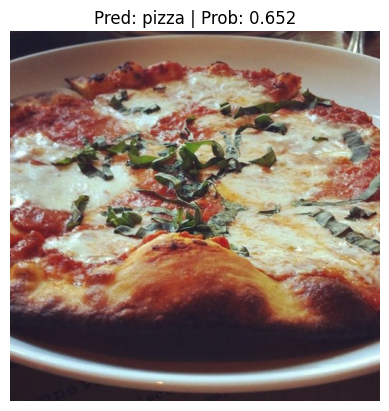

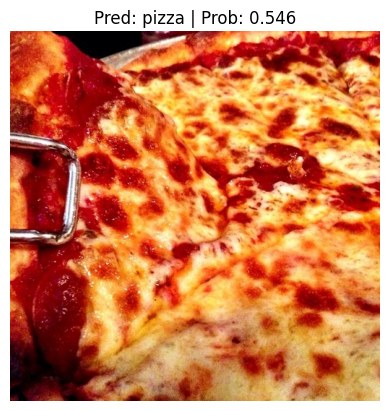

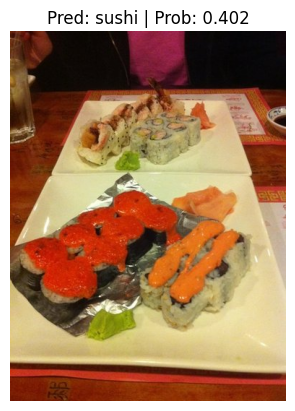

In [35]:
# Get a random list of image paths from the test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                        k=num_images_to_plot)


# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224,224))

### 6.1 Making predictions on a custom image


In [36]:
# Download the image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download th eif it doesn't exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # Downlaod the image from Github with "raw" link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Download {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping downlaod...")



Download data/04-pizza-dad.jpeg...


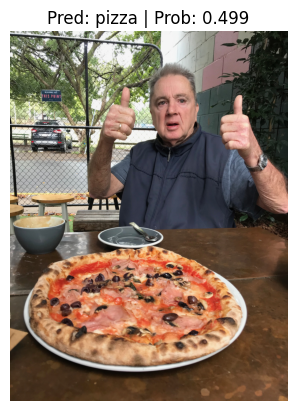

In [37]:
# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

## Main takeaways

* **Transfer learning** often allows to you get good results with relatively small amout of custom data.

* Knowing th epower of transfer learning, it's good idea to ask at the start of every problem, "does an existing well-performing model exist for my problem"

* When using a pretrained model, it's important that your custom data be formatted/preprocessed in the same way that the original model was trained on, otherwise you may get degraded performance.

* The same goes for predicting on custom data, ensure your custom data is in the same format as the data your model was trained on.

* There are several different places to find pretrained models from th ePyTorch domain libraries, HuggingFace Hub and libraries such as `timm`